[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1hR92YKQZ6_PWoeOEH8TWe9MjPbFx5FAr)

#$Imports$

In [ ]:
# Common
import numpy as np
import pandas as pd
# Spliting
from sklearn.model_selection import train_test_split
# Feture Selection
from sklearn.ensemble import RandomForestClassifier
# Visualization
import matplotlib.pyplot as plt
# Models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
# Evaluation
from sklearn.metrics import confusion_matrix, f1_score
# Tuning
from sklearn.model_selection import GridSearchCV
# Scaler
from sklearn.preprocessing import StandardScaler

#$Data$

In [ ]:
df = pd.read_csv("heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Ahhh great!!, the data is good as it does not have categorical values. Let's check for the null values.

In [ ]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

$Great!!$ There are `no null values`. I think some of the `features` like the `"sex"` does `not affect` the `data`, so in `order` to `check` it let's do `feature selection`.

In [ ]:
X_data = df.iloc[:,:-1]
Y_data = df['target']
print(f" CD : {np.bincount(Y_data)}")

 CD : [138 165]


There is `not` much `Class Imbalance`. Hence, `no need` of `Resampling or Stratifying`.

#$Spliting$ $Data$

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X_data,Y_data,test_size=0.2)

In [ ]:
print(f"X Train : {X_train.shape}")
print(f"Y Train : {Y_train.shape}")
print(f"X Test : {X_test.shape}")
print(f"Y Test : {Y_test.shape}")

X Train : (242, 13)
Y Train : (242,)
X Test : (61, 13)
Y Test : (61,)


Yeah!!, good let's move to feature selection/importnace.

#$Feature$ $Importance$

In [ ]:
RFC = RandomForestClassifier().fit(X_train,Y_train)
feature_imp_ = RFC.feature_importances_

In [ ]:
X_cols = X_data.columns
X_cols

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

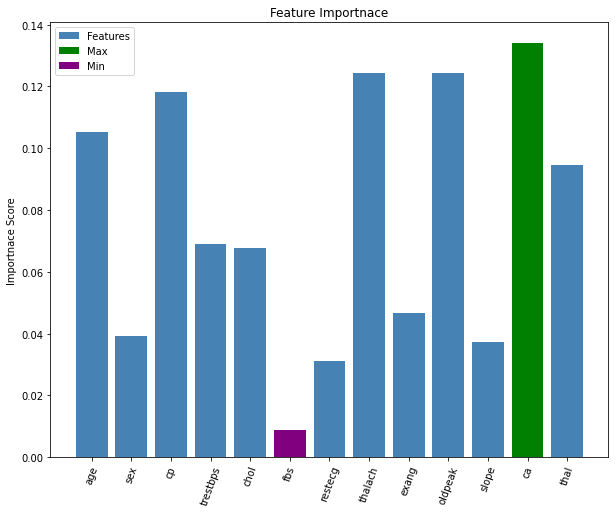

In [ ]:
plt.figure(figsize=(10,8))
plt.bar(X_cols,feature_imp_,color="steelblue",label="Features")
plt.bar(X_cols[np.where(feature_imp_==feature_imp_.max())],feature_imp_.max(),color="green",label="Max")
plt.bar(X_cols[np.where(feature_imp_==feature_imp_.min())],feature_imp_.min(),color="purple",label="Min")
plt.xticks(rotation=70)
plt.legend()
plt.ylabel("Importnace Score")
plt.title("Feature Importnace")
plt.show()

As we can see $"fbs"$ and $"restecg"$ are `not that important` compare to others, we can `remove` them from the `dataset`. This will `save training time` and `model` will `generalize better`. But this is a `small dataset` that's why I am `not removing it`.

#$Models$

##Function

In [ ]:
def evaluation(model):
  y_pred_model = model.predict(X_test)
  print(f"Accuracy : {model.score(X_test,Y_test)}")
  print(f"CM : \n {confusion_matrix(Y_test,y_pred_model)}")
  print(f"F1 Score  : {f1_score(Y_test,y_pred_model)}")

##$SVC$

In [ ]:
vector_machine = SVC()
vector_machine.fit(X_train,Y_train)
evaluation(vector_machine)

Accuracy : 0.6721311475409836
CM : 
 [[14 10]
 [10 27]]
F1 Score  : 0.7297297297297297


Let's Try tuning it

In [ ]:
gs_svc = GridSearchCV(vector_machine,param_grid={"C":[0.001,0.01,0.1,1.0,10.0,100.0]},cv=10)
gs_svc.fit(X_train,Y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
gs_svc.best_params_

{'C': 100.0}

In [ ]:
best_svc = gs_svc.best_estimator_
best_svc.fit(X_train,Y_train)
evaluation(best_svc)

Accuracy : 0.7540983606557377
CM : 
 [[19  5]
 [10 27]]
F1 Score  : 0.7826086956521738


A little better not much. Scaling the input may help.

In [ ]:
Sc = StandardScaler()
X_train_sc, X_test_sc = Sc.fit_transform(X_train), Sc.transform(X_test) 

In [ ]:
scaled_svc = gs_svc.best_estimator_
scaled_svc.fit(X_train_sc,Y_train)
evaluation(scaled_svc)

Accuracy : 0.6065573770491803
CM : 
 [[ 0 24]
 [ 0 37]]
F1 Score  : 0.7551020408163265


Nahh!!!. Let's keep the previous version only.

##$RandomForest$

In [ ]:
RFC = RandomForestClassifier(max_depth=10)
RFC.fit(X_train,Y_train)
evaluation(RFC)

Accuracy : 0.819672131147541
CM : 
 [[21  3]
 [ 8 29]]
F1 Score  : 0.8405797101449275


My expectations was more than the results

In [ ]:
gs_rfc = GridSearchCV(RFC,param_grid={"max_depth":[10,30,50,70,100],"n_estimators":[100,200,300,500]},cv=5)
gs_rfc.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=10,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_

In [ ]:
gs_rfc.best_params_

{'max_depth': 50, 'n_estimators': 100}

In [ ]:
best_rfc = gs_rfc.best_estimator_
best_rfc.fit(X_train,Y_train)
evaluation(best_rfc)

Accuracy : 0.819672131147541
CM : 
 [[20  4]
 [ 7 30]]
F1 Score  : 0.8450704225352113


This time too, let's keep the normal one.

##$AdaBoost$

In [ ]:
AdaBC = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),n_estimators=100,learning_rate=1.0)
AdaBC.fit(X_train,Y_train)
evaluation(AdaBC)

Accuracy : 0.7704918032786885
CM : 
 [[22  2]
 [12 25]]
F1 Score  : 0.7812500000000001


In [ ]:
gs_ada = GridSearchCV(AdaBC,param_grid={"learning_rate":[0.001,0.01,0.1,1.0,10.0,100.0],"n_estimators":[50,100,200,300,500]},cv=5,scoring="accuracy")
gs_ada.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=10,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
   

In [ ]:
gs_ada.best_params_

{'learning_rate': 0.01, 'n_estimators': 500}

In [ ]:
gs_ada.best_score_

0.7398809523809524

In [ ]:
best_ada = gs_ada.best_estimator_
best_ada.fit(X_train,Y_train)
evaluation(best_ada)

Accuracy : 0.7540983606557377
CM : 
 [[22  2]
 [13 24]]
F1 Score  : 0.7619047619047619


##$DecisionTree$

In [ ]:
DTC = DecisionTreeClassifier(max_depth=10)
DTC.fit(X_train,Y_train)
evaluation(DTC)

Accuracy : 0.7213114754098361
CM : 
 [[22  2]
 [15 22]]
F1 Score  : 0.7213114754098361


In [ ]:
gs_dtc = GridSearchCV(DTC,param_grid={"max_depth":[50,10,20,30,80,100]},cv=5,scoring="accuracy")
gs_dtc.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=10,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [50, 10, 20, 30, 80, 100]},
             p

In [ ]:
best_dtc = gs_dtc.best_estimator_
best_dtc.fit(X_train,Y_train)
evaluation(best_dtc)

Accuracy : 0.7377049180327869
CM : 
 [[22  2]
 [14 23]]
F1 Score  : 0.7419354838709677


##$Kmeans$

In [ ]:
Kmeans = KMeans(n_clusters=2)
Kmeans.fit(X_train,Y_train)
evaluation(Kmeans) # Accuracy(i.e. score) gives -ve of inertia.

Accuracy : -215380.50675946978
CM : 
 [[16  8]
 [ 8 29]]
F1 Score  : 0.7837837837837838


##$Gausian$ $Mixture$

In [ ]:
gmm = GaussianMixture(n_components=2)
gmm.fit(X_train,Y_train)
evaluation(gmm) # Accuracy(i.e. score) gives -ve of inertia.

Accuracy : -22.074552284843524
CM : 
 [[17  7]
 [24 13]]
F1 Score  : 0.456140350877193


#$Cause$
---
Interesting, no one is able to perform more than 80%

----
Cause for such a low accuracy :
1. $Small$ $Dataset$

---

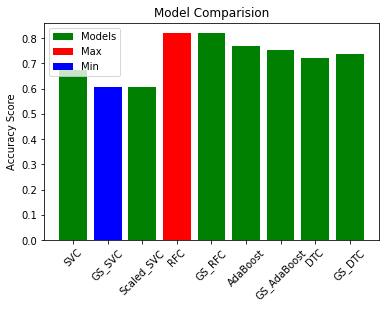

In [ ]:
def best_model(models,X_test,Y_test,n_):
  acc_ = []
  for i in models:
    acc = i.score(X_test,Y_test)
    acc_.append(acc)
  plt.bar(n_,acc_,color="green",label="Models")
  plt.bar(n_[acc_.index(np.max(acc_))],np.max(acc_),color="red",label="Max")
  plt.bar(n_[acc_.index(np.min(acc_))],np.min(acc_),color="blue",label="Min")
  plt.title("Model Comparision")
  plt.legend()
  plt.xticks(rotation=45)
  plt.ylabel("Accuracy Score")
  plt.show()
models = [vector_machine,best_svc,scaled_svc,RFC,best_rfc,AdaBC,best_ada,DTC,best_dtc]
best_model(models,X_test,Y_test,n_=["SVC","GS_SVC","Scaled_SVC","RFC","GS_RFC","AdaBoost","GS_AdaBoost","DTC","GS_DTC"])

We can `conclude` that $RFC$ works `best` for this `problem`.

----